# adult dataset 

In [1]:
# Imports
import numpy as np
import pandas as pd

# Opendataval
from opendataval.dataloader import Register, DataFetcher, mix_labels, add_gauss_noise
from opendataval.dataval import (
    AME,
    DVRL,
    BetaShapley,
    DataBanzhaf,
    DataOob,
    DataShapley,
    InfluenceSubsample,
    KNNShapley,
    LavaEvaluator,
    LeaveOneOut,
    LossValEvaluator,
    RandomEvaluator
)

from opendataval.experiment import ExperimentMediator

[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


## [Step 1] Set up an environment
`ExperimentMediator` is a fundamental concept in establishing the `opendataval` environment. It empowers users to configure hyperparameters, including a dataset, a type of synthetic noise, and a prediction model. With  `ExperimentMediator`, users can effortlessly compute various data valuation algorithms.

The following code cell demonstrates how to set up `ExperimentMediator` with a pre-registered dataset and a prediction model.
- Dataset: adult
- Model: sklearn's logistic regression model
- Metric: Classification accuracy

In [2]:
dataset_name = "adult"
train_count, valid_count, test_count = 1000, 100, 500
noise_rate = 0.2
noise_kwargs = {'noise_rate': noise_rate}
model_name = "sklogreg"
metric_name = "accuracy"

exper_med = ExperimentMediator.model_factory_setup(
    dataset_name=dataset_name,
    cache_dir="../data_files/",  
    force_download=False,
    train_count=train_count,
    valid_count=valid_count,
    test_count=test_count,
    add_noise=mix_labels, 
    noise_kwargs=noise_kwargs,
    train_kwargs={},
    model_name=model_name,
    metric_name=metric_name
)

Base line model metric_name='accuracy': perf=0.7960000038146973


A full list of registered datasets can be found [here](https://github.com/opendataval/opendataval/blob/main/opendataval/dataloader/fetcher.py#L121). A list of available  prediction models can be found [here](https://github.com/opendataval/opendataval/blob/main/opendataval/model/__init__.py#L111).

## [Step 2] Compute data values
`opendataval` provides various state-of-the-art data valuation algorithms. `ExperimentMediator.compute_data_values()` computes data values.

In [3]:
data_evaluators = [ 
    RandomEvaluator(),
    LeaveOneOut(), # leave one out
    InfluenceSubsample(num_models=1000), # influence function
    DVRL(rl_epochs=2000), # Data valuation using Reinforcement Learning
    KNNShapley(k_neighbors=valid_count), # KNN-Shapley
    DataShapley(cache_name=f"cached"), # Data-Shapley
    BetaShapley(cache_name=f"cached"), # Beta-Shapley
    DataBanzhaf(num_models=1000), # Data-Banzhaf
    AME(num_models=1000), # Average Marginal Effects
    DataOob(num_models=1000), # Data-OOB
    LavaEvaluator(),
    LossValEvaluator(is_classification=True, nr_epochs=15) # LossVal
]

In [4]:
%%time
# compute data values.
exper_med = exper_med.compute_data_values(data_evaluators=data_evaluators)

Elapsed time RandomEvaluator(): 0:00:00.002308


100%|██████████| 1000/1000 [00:14<00:00, 69.45it/s]


Elapsed time LeaveOneOut(): 0:00:14.416266


100%|██████████| 1000/1000 [00:13<00:00, 76.38it/s]


Elapsed time InfluenceSubsample(num_models=1000): 0:00:13.095493


100%|██████████| 2000/2000 [00:13<00:00, 149.53it/s]


Elapsed time DVRL(rl_epochs=2000): 0:00:13.440491


100%|██████████| 999/999 [00:00<00:00, 8122.04it/s]

Elapsed time KNNShapley(k_neighbors=100): 0:00:00.160311
Start: marginal contribution computation



100%|██████████| 100/100 [01:22<00:00,  1.22it/s]


gr_stat=100


100%|██████████| 100/100 [01:11<00:00,  1.41it/s]


gr_stat=100


100%|██████████| 100/100 [00:41<00:00,  2.44it/s]


gr_stat=100


100%|██████████| 100/100 [01:13<00:00,  1.37it/s]


gr_stat=100


100%|██████████| 100/100 [01:01<00:00,  1.64it/s]

gr_stat=1.0287592871315223
Total number of trained models to estimate marginal
               contributions: 48162
Done: marginal contribution computation


Elapsed time DataShapley(cache_name=cached): 0:05:28.416001
Elapsed time BetaShapley(cache_name=cached): 0:00:00.003441


100%|██████████| 1000/1000 [00:12<00:00, 79.13it/s]


Elapsed time DataBanzhaf(num_models=1000): 0:00:12.657912


100%|██████████| 1000/1000 [00:13<00:00, 75.66it/s]


Elapsed time AME(num_models=1000): 0:00:47.189722


100%|██████████| 1000/1000 [00:19<00:00, 50.43it/s]


Elapsed time DataOob(num_models=1000): 0:00:19.838984


Elapsed time LavaEvaluator(): 0:00:00.102847
Elapsed time LossValEvaluator(nr_epochs=15): 0:00:05.569127
CPU times: total: 12min 10s
Wall time: 7min 34s


## [Step 3] Evaluate data values

In [5]:
from opendataval.experiment.exper_methods import (
    discover_corrupted_sample,
    noisy_detection,
    remove_high_low,
    save_dataval
)
from matplotlib import pyplot as plt

# Saving the results
output_dir = f"../tmp/{dataset_name}_{noise_rate=}/"
exper_med.set_output_directory(output_dir)
output_dir

'../tmp/adult_noise_rate=0.2/'

### Noisy data detection 
- `noisy_detection` performs the noisy data detection task and evaluates the F1-score of each data valuation algorithm's prediction. The higher, the better.  
  - noisy data: mislabeled data

In [6]:
exper_med.evaluate(noisy_detection, save_output=True)

,kmeans_f1
AME(num_models=1000),0.255034
BetaShapley(cache_name=cached),0.480226
DVRL(rl_epochs=2000),0.508539
DataBanzhaf(num_models=1000),0.336158
DataOob(num_models=1000),0.631373
DataShapley(cache_name=cached),0.478134
InfluenceSubsample(num_models=1000),0.298720
KNNShapley(k_neighbors=100),0.560784
LavaEvaluator(),0.018868
LeaveOneOut(),0.283286


### Discover noisy samples
- `discover_corrupted_sample` visualizes how well noisy data points are identified when a fraction of dataset is inspected. 

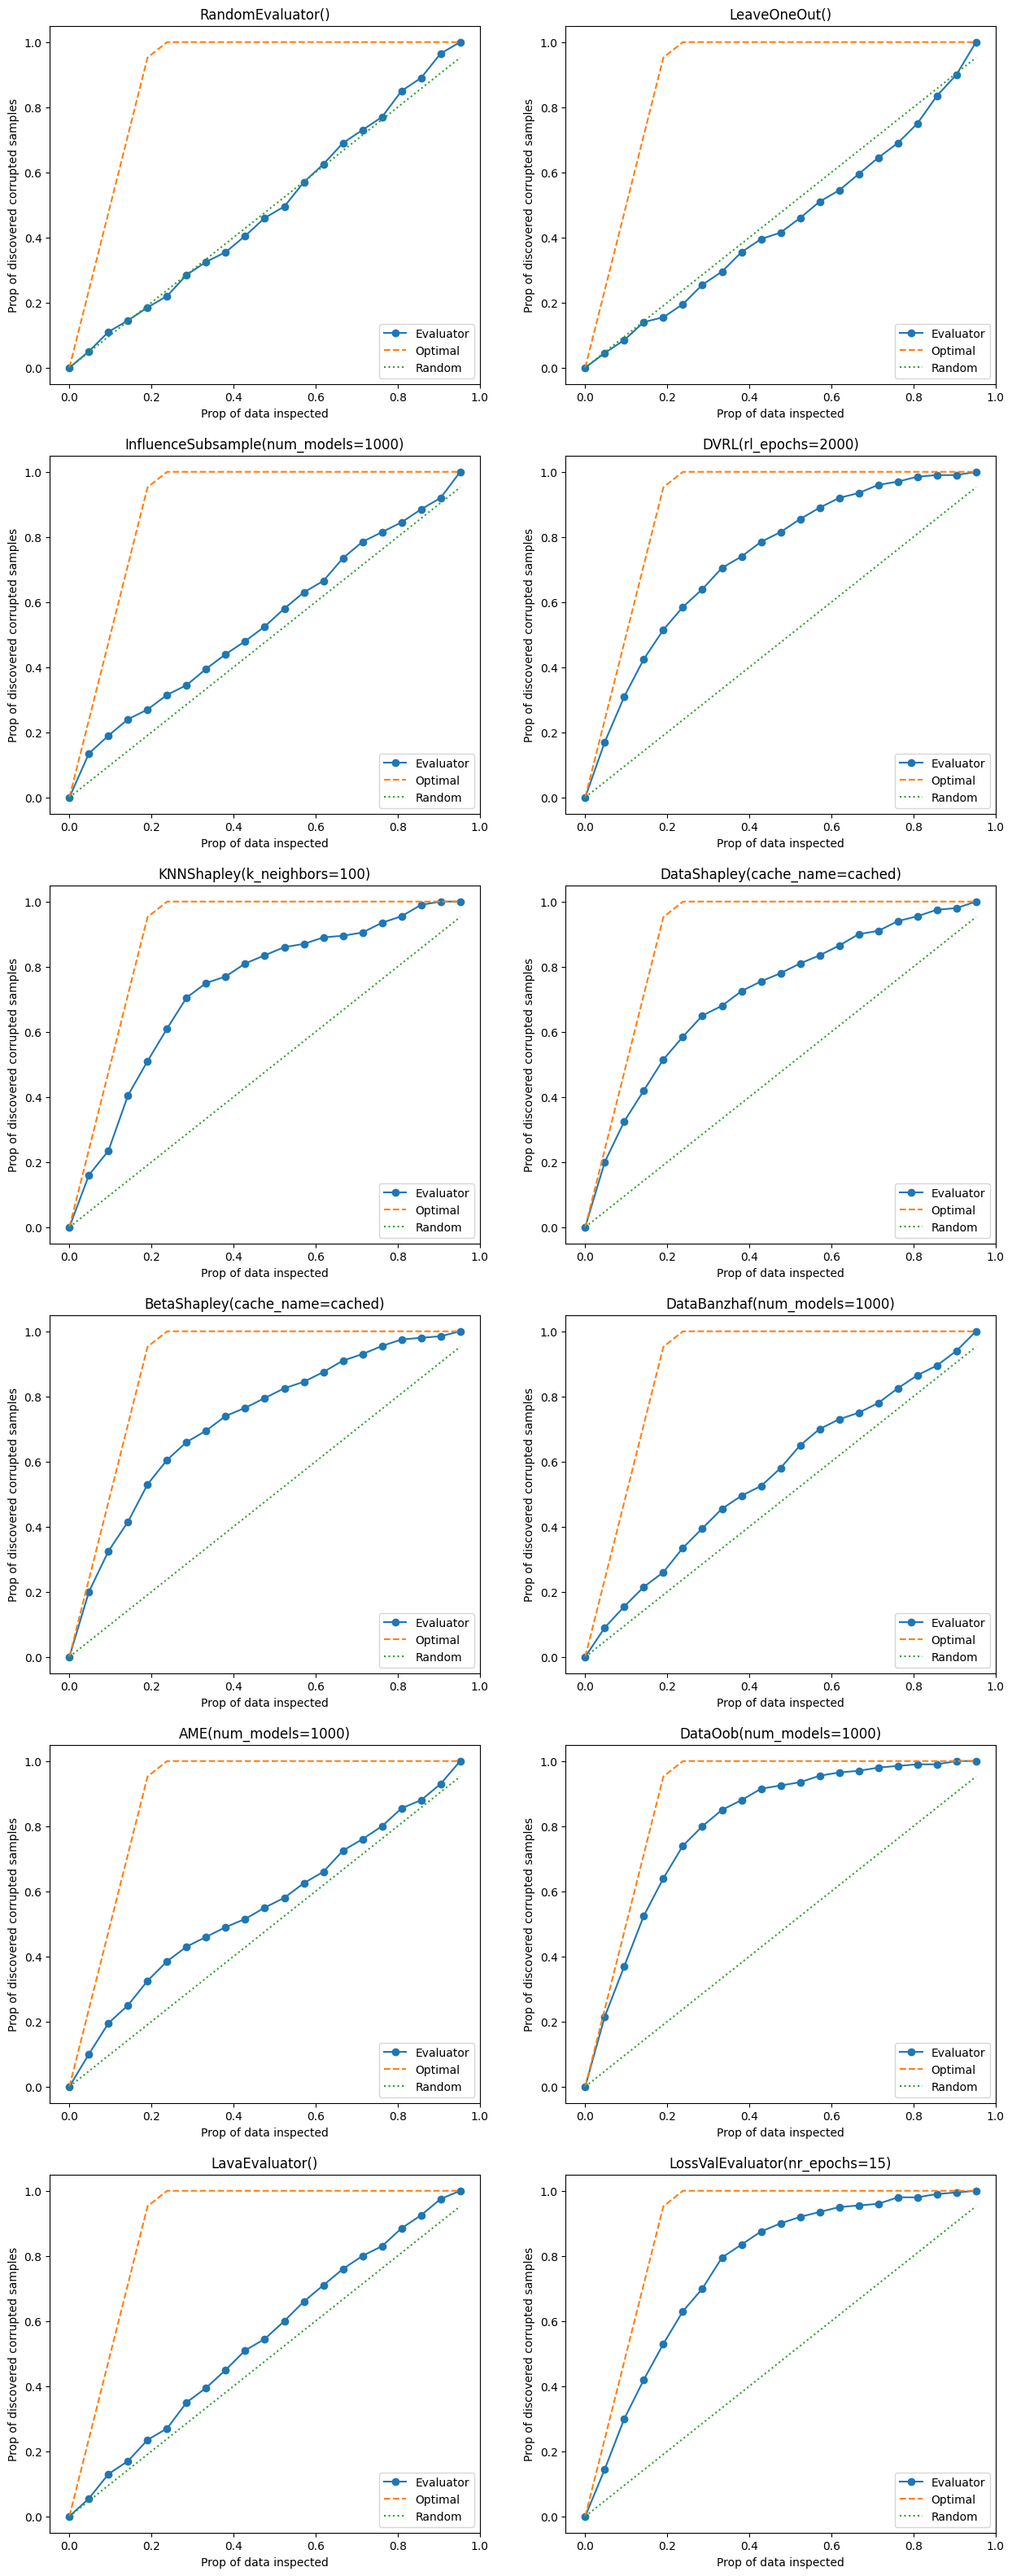

In [7]:
fig = plt.figure(figsize=(15, 40))
df, fig = exper_med.plot(discover_corrupted_sample, fig, col=2, save_output=True)

### Point removal experiment
- `remove_high_low` performs the point removal experiment. Each data valution algorithm, it provides two curves: one is removing data in a descending order (orange), the other is in an ascending order (blue). As for the orange (resp. blue) curve, the lower (resp. upper), the better. 

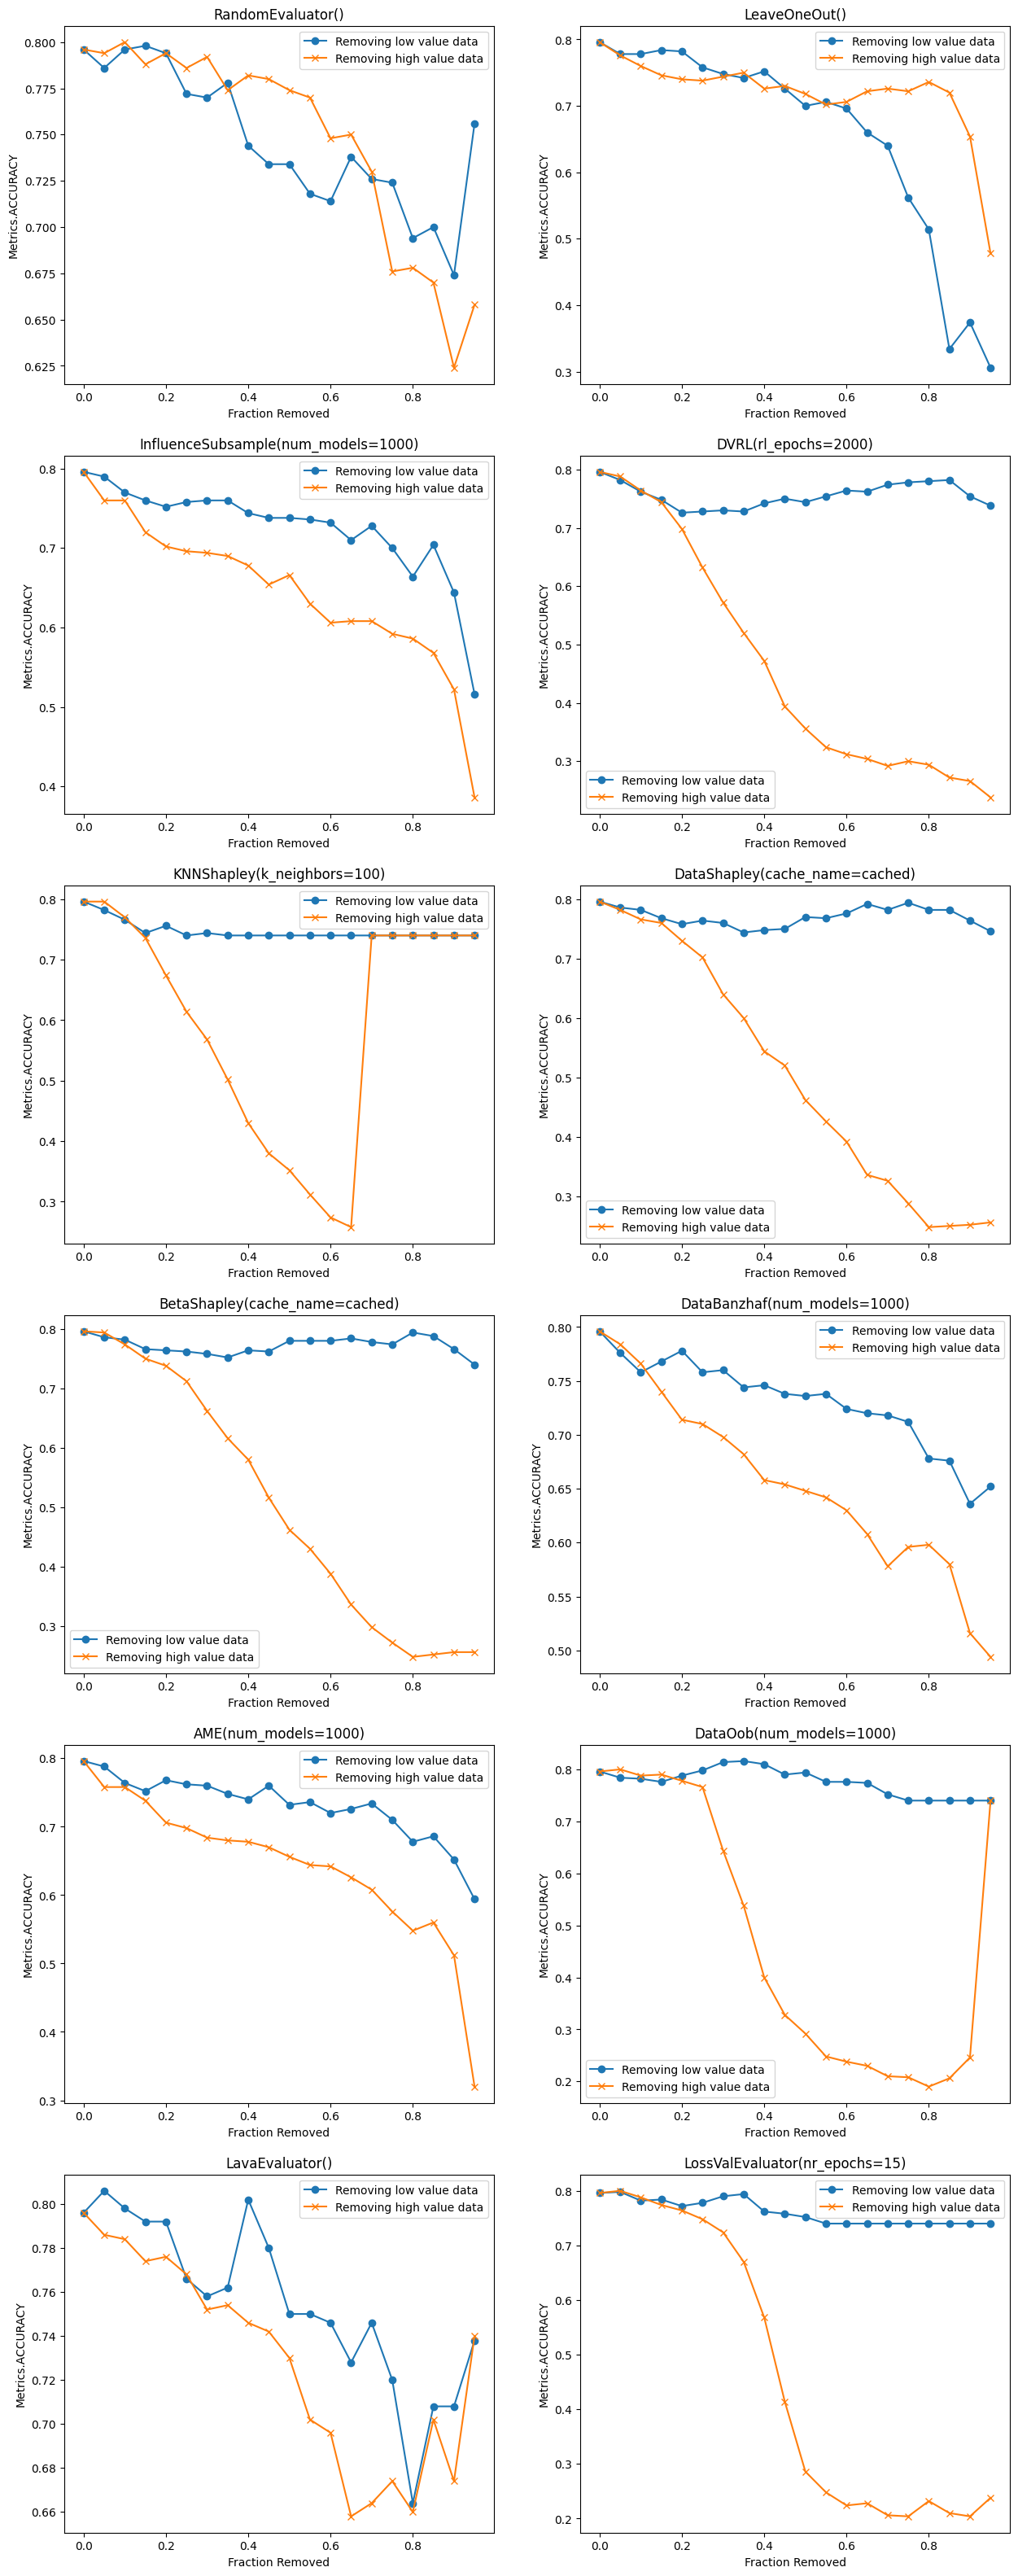

In [8]:
fig = plt.figure(figsize=(15, 40))
df_resp, fig = exper_med.plot(remove_high_low, fig, col=2, save_output=True)

In [9]:
df_resp # it provides complete information for generating point-removal experiment figures.

,remove_least_influential_first_Metrics.ACCURACY,remove_most_influential_first_Metrics.ACCURACY,axis
RandomEvaluator(),0.796,0.796,0.0
RandomEvaluator(),0.786,0.794,0.05
RandomEvaluator(),0.796,0.8,0.1
RandomEvaluator(),0.798,0.788,0.15
RandomEvaluator(),0.794,0.794,0.2
...,...,...,...
LossValEvaluator(nr_epochs=15),0.74,0.204,0.75
LossValEvaluator(nr_epochs=15),0.74,0.232,0.8
LossValEvaluator(nr_epochs=15),0.74,0.21,0.85
LossValEvaluator(nr_epochs=15),0.74,0.204,0.9


### Save data values
- `save_dataval` stores computed data values at `{output_dir}/save_dataval.csv`.

In [10]:
exper_med.evaluate(save_dataval, save_output=True)

,indices,data_values
RandomEvaluator(),3634,0.487519
RandomEvaluator(),44748,0.584142
RandomEvaluator(),30507,0.774522
RandomEvaluator(),24236,0.420114
RandomEvaluator(),8341,0.836535
...,...,...
LossValEvaluator(nr_epochs=15),98,1.498906
LossValEvaluator(nr_epochs=15),15740,1.721501
LossValEvaluator(nr_epochs=15),27277,1.539658
LossValEvaluator(nr_epochs=15),31266,0.247965
